<h2>Getting design recommendations of a tablet with single input.</h2>

<h3>Setup</h3>

Edit search function here.

In [4]:
search_term="galaxy tab s9 fe"       #edit search here
OPENAI_API_KEY="xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"    #enter openai API key here
key="xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"       #enter youtube api key here
max_result = 10         #enter number of youtube videos here
pages_limit=10          #enter number of amazon review pages
number_of_competitors=5         #enter number of competitors to compare to


Download and import all libraries.

In [ ]:
! pip install pandas
! pip install google-api-python-client
! pip install youtube-transcript-api
! pip install youtube_dl
! pip install beautifulsoup4
! pip install undetected_chromedriver
! pip install deep_translator
! pip install nltk
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install transformers[torch]
! pip install matplotlib
! pip install langchain==0.1.9 chromadb==0.4.24 langchain-openai==0.0.8
! pip install seaborn

In [5]:
import pickle
import os
import pandas as pd
from googleapiclient.discovery import build
import youtube_dl
from youtube_transcript_api import YouTubeTranscriptApi
import requests
import webbrowser
from bs4 import BeautifulSoup
import random
import json
import undetected_chromedriver as uc
import time
import csv
import re
from selenium.webdriver.common.by import By
from transformers import pipeline
from deep_translator import GoogleTranslator
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
from selenium import webdriver

c:\Users\Matthew\Desktop\proj 2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
try:                                              # Create directory named after search terms
    os.makedirs("data/%s" % search_term)
    print("Directory", search_term, "created")
except FileExistsError:
    print("Directory", search_term, "exists")
data_dir=f'data/{str(search_term)}'

Directory galaxy tab s9 fe exists


<h3>Getting all competitors by year released and size</h3>

In [6]:
products=[]

#going to gsmarena search page
gsmurl=f"https://www.gsmarena.com/res.php3?sSearch={search_term}"
driver = webdriver.Chrome()
driver.get(gsmurl)


#taking the first result to get the official name and gsm webpage of the tablet with selenium
ul_elements = driver.find_elements(By.CSS_SELECTOR,"ul")
xx=0
for ul in ul_elements:
    if xx==5:
        this=ul.get_attribute("outerHTML")
    xx+=1
name=this.split("br")
name=name[1].split(">")
name=name[1].split("<")
products.append(name[0])
x=this.split("href")
x=x[1].split(">")
x=x[0].split('"')
link="https://www.gsmarena.com/"+x[1]

#getting year and height of tablet with request and gsm webpage
html = requests.get(link)
doc = BeautifulSoup(html.content,"html.parser")
tags=doc.find_all("td",{"class":"nfo", "data-spec":"year"})
year=tags[0].string[:4]
tags=doc.find_all("td",{"class":"nfo", "data-spec":"dimensions"})
height=int(float(tags[0].string[:5]))
def round_to_nearest_5(num):
    # Round the number to the nearest multiple of 5
    rounded_num = round(num / 5) * 5
    return rounded_num

#searching similar tablets by year release and size
searchurl=f"https://www.gsmarena.com/search.php3?mode=tablet&nYearMin={year}&nYearMax={year}&nHeightMin={height-10}&nHeightMax={height+10}&sMakers=76,48,58,73,9,80&sAvailabilities=1"
driver.get(searchurl)
time.sleep(2)
driver.find_elements(By.CSS_SELECTOR,'.pf-button')[0].click()
ul_elements = driver.find_elements(By.CSS_SELECTOR,"ul")
xx=0
for ul in ul_elements:
    if xx==5:
        this=ul.get_attribute("outerHTML")
    xx+=1
name=this.split("title")
for aaasd in range(len(name)):
    if aaasd>0 and aaasd<number_of_competitors+1:
        x=name[aaasd].split('"')
        x=x[1].split(".")
        x=x[0].split()
        final=' '.join(x[:-2])
        products.append(final)
driver.quit()

#shows name of productor and competitors products
print(products)

pickle.dump(products, open(f'{data_dir}/products.pkl', "wb"))

['Galaxy Tab S9 FE', 'Xiaomi Pad 6', 'Samsung Galaxy Tab A9+', 'Samsung Galaxy Tab A9', 'Xiaomi Redmi Pad SE', 'Samsung Galaxy Tab S9 FE']


In [66]:
pickle.dump(products, open(f'{data_dir}/products.pkl', "wb"))

Create file directory for all products

In [7]:
for prod in products:
    try:                                              # Create directory named after search terms
        os.makedirs(f"data/{search_term}/{prod}")
        print("Directory", search_term,prod, "created")
    except FileExistsError:
        print("Directory", search_term,prod, "exists")
    data_dir=f'data/{str(search_term)}'

Directory galaxy tab s9 fe Galaxy Tab S9 FE created
Directory galaxy tab s9 fe Xiaomi Pad 6 created
Directory galaxy tab s9 fe Samsung Galaxy Tab A9+ created
Directory galaxy tab s9 fe Samsung Galaxy Tab A9 created
Directory galaxy tab s9 fe Xiaomi Redmi Pad SE created
Directory galaxy tab s9 fe Samsung Galaxy Tab S9 FE created


<h3>Scraping Amazon Reviews</h3>

Creating new variable

In [8]:
reviewlist=[]

Amazon scraping setup (getting user-agent to bypass amazon anti scraping measure).

In [9]:
url = f"https://www.amazon.com/s?k={products[0]}"
f = open("useragent.txt", "r")
data = f.readlines()[random.randint(1,100)*2-1][:-2]
f.close()
HEADERS = ({'User-Agent':str(data),
            'Accept-Language': 'en-US, en;q=0.5'})
print(HEADERS['User-Agent'])

Mozilla/5.0 (Macintosh; Intel Mac OS X 10_3_6) AppleWebKit/535.7 (KHTML, like Gecko) Chrome/54.0.2415.228 Safari/60


Opening new window to scrape amazon (bypass amazon's anti scrape by login)

In [10]:
# Amazon Login to bypass anti-scraping measure
chromeOptions = uc.ChromeOptions()
chromeOptions.headless = False
driver = uc.Chrome(use_subprocess=True, options=chromeOptions, headers=HEADERS)
csv_filename = f'{search_term} reviews.csv'


Login to bypass measure

In [12]:
driver.get("https://www.amazon.com/ap/signin?openid.pape.max_auth_age=0&openid.return_to=https%3A%2F%2Fwww.amazon.com%2F%3Fref_%3Dnav_signin&openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.assoc_handle=usflex&openid.mode=checkid_setup&openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0")
time.sleep(1) # Wait for a few seconds to ensure the page loads completely
email = driver.find_element(By.ID, "ap_email")
email.send_keys("samiraonly70@gmail.com")
driver.find_element(By.ID, "continue").click()
time.sleep(1)
password = driver.find_element(By.ID, "ap_password")
password.send_keys("pp11qq")
driver.find_element(By.ID, "signInSubmit").click()  
time.sleep(1)

Open new window to scrape up to 100 reviews

In [ ]:
from selenium.common.exceptions import ElementNotInteractableException
templist=[]
url = f"https://www.amazon.com/s?k={products[0]}"
driver.get(url)
ss=driver.find_elements(By.CSS_SELECTOR,".a-link-normal")
time.sleep(2)
ss[0].click()
ss=driver.find_elements(By.XPATH, "//*[text()='See more reviews']")
ss[0].click()
for i in range(pages_limit):
    time.sleep(1.5)
    # Locate and extract review elements
    review_elements = driver.find_elements(By.CSS_SELECTOR, '.a-section.review')
    for review_element in review_elements:
        # Extract the author's name
        author_name = review_element.find_element(By.CLASS_NAME, 'a-profile-name').text.encode()
        # Extract review text
        review_text = review_element.find_element(By.CLASS_NAME, 'review-text').text.encode()
        # Extract review date
        review_date = review_element.find_element(By.CLASS_NAME, 'review-date').text.encode()
        list_of_info=[author_name.decode(), review_text.decode(), review_date.decode()]
        templist.append(list_of_info)
    try:
        ss=driver.find_elements(By.XPATH, "//*[text()='Next page']")
        ss[0].click()
    except ElementNotInteractableException:
        break
reviewlist.append(templist)
csv_filename = f'{products[0]} reviews.csv'

Saving it as csv

In [15]:
with open(f'{data_dir}/{products[0]}/{csv_filename}', 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Author', 'Review', 'Review Date'])
    for review in templist:
        csv_writer.writerow(review)

Repeating for all other competitors

In [ ]:
for prodno in range(1,len(products)):
    templist=[]
    url = f"https://www.amazon.com/s?k={products[prodno]}"
    driver.get(url)
    ss=driver.find_elements(By.CSS_SELECTOR,".a-link-normal")
    time.sleep(2)
    ss[0].click()
    ss=driver.find_elements(By.XPATH, "//*[text()='See more reviews']")
    ss[0].click()
    for i in range(pages_limit):
        time.sleep(1.5)
        # Locate and extract review elements
        review_elements = driver.find_elements(By.CSS_SELECTOR, '.a-section.review')
        for review_element in review_elements:
            # Extract the author's name
            author_name = review_element.find_element(By.CLASS_NAME, 'a-profile-name').text.encode()
            # Extract review text
            review_text = review_element.find_element(By.CLASS_NAME, 'review-text').text.encode()
            # Extract review date
            review_date = review_element.find_element(By.CLASS_NAME, 'review-date').text.encode()
            list_of_info=[author_name.decode(), review_text.decode(), review_date.decode()]
            templist.append(list_of_info)
        try:
            ss=driver.find_elements(By.XPATH, "//*[text()='Next page']")
            ss[0].click()
        except (ElementNotInteractableException, IndexError):
            break   
    reviewlist.append(templist)
    csv_filename = f'{products[prodno]} reviews.csv'
    with open(f'{data_dir}/{products[prodno]}/{csv_filename}', 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Author', 'Review', 'Review Date'])
        for review in templist:
            csv_writer.writerow(review)
driver.close()

<h3> Getting Youtube caption and comments</h3>

Setup for Youtube caption and comments

In [17]:
youtube = build('youtube', 'v3', developerKey=key)
vid_id = []             	# video id
vid_page = []       		# video links (https...)
vid_title = []              # video title
num_comments = []           # official number of comments
load_error = 0              # error counter
can_load_title = []         # temp. list for storing title w/o loading error
can_load_page = []          # temp. list for storing links w/o loading error
num_page = []               # comment_response page number
page_title = []             # comment_response video title
comment_resp = []           # comment_response
comment_list = []           # temp. list for storing comments
comment_data = []           # comments & replies from comment_response
caption_list = []           # caption list
all_count = 0               # total number of comments
search_list=[]

Getting Youtube search results

In [18]:
print("Search for Videos IDs...")
for i in range(len(products)):
    request = youtube.search().list(
        q=products[i]+" review",
        maxResults=max_result,
        part="id",
        type="video",
        videoCaption="closedCaption",
        videoDuration="medium"    
        )
    search_response = request.execute()
    search_list.append(search_response)
    print(search_response)

Search for Videos IDs...
{'kind': 'youtube#searchListResponse', 'etag': 't-RPA6DSB5sRr9Ft_wjKyXQcZ8A', 'nextPageToken': 'CAoQAA', 'regionCode': 'SG', 'pageInfo': {'totalResults': 3092, 'resultsPerPage': 10}, 'items': [{'kind': 'youtube#searchResult', 'etag': 'VbTNVcUslfR6FcBCOxcQPMWXLps', 'id': {'kind': 'youtube#video', 'videoId': 'hpTkMS_Pvz8'}}, {'kind': 'youtube#searchResult', 'etag': 'Wbh7Ei2Td-mbTi8tNZpnX5ACgnU', 'id': {'kind': 'youtube#video', 'videoId': '_ncEocsH_t4'}}, {'kind': 'youtube#searchResult', 'etag': 'KAwnGn9nrRFgy9gaDirUZlNnLWI', 'id': {'kind': 'youtube#video', 'videoId': 'S_e7Q-5S3ss'}}, {'kind': 'youtube#searchResult', 'etag': 'I4IdPA4FTiT_G0RMWBNv0e49Msk', 'id': {'kind': 'youtube#video', 'videoId': 'jEssZLj87fY'}}, {'kind': 'youtube#searchResult', 'etag': 'WGi-nvgNk9NiaeF0FamZF9fKrmQ', 'id': {'kind': 'youtube#video', 'videoId': 'IyuimYkRPQc'}}, {'kind': 'youtube#searchResult', 'etag': 'gNB8RIbc8RX3iR7wfdpnYTTUI4Q', 'id': {'kind': 'youtube#video', 'videoId': 'dA8R0X

Function to remove punctuations

In [19]:
def remove_punctuation(input_string):
    # Define a regular expression pattern to match alphanumeric characters
    pattern = re.compile(r'\W+', re.UNICODE)
    
    # Use the pattern to replace non-alphanumeric characters with an empty string
    result = re.sub(pattern, ' ', input_string)
    
    return result

Saving search results

In [20]:
print("Videos found...")
for j in range(len(products)):
    temp1=[]
    temp=[]
    for k in range(max_result):
        videoId = search_list[j]['items'][k]['id']['videoId']
        print(videoId)
        temp1.append(videoId)                          # a list of Video IDs
        page = "https://www.youtube.com/watch?v=" + videoId
    print(temp1)
    vid_id.append(temp1)
    print("\nThere are", len(temp1), "videos.")

    print("Get video data...")
    for i in range(len(vid_id[j])):
        request = youtube.videos().list(
            part="snippet, statistics",
            id=vid_id[j][i]
            )
        video_response = request.execute()

        title = remove_punctuation(video_response['items'][0]['snippet']['title'])
        print(title)
        temp.append(title)
        try:                        # use try/except as some videos might not load
            comment_count = video_response['items'][0]['statistics']['commentCount']
            print("Video", i + 1, "-", title, "-- Comment count: ", comment_count)
            print()
            num_comments.append(comment_count)
        except:
            print("Video", i + 1, "-", title, "-- Comments are turned off")
            print()
            num_comments.append(0)
    vid_title.append(temp)

Videos found...
hpTkMS_Pvz8
_ncEocsH_t4
S_e7Q-5S3ss
jEssZLj87fY
IyuimYkRPQc
dA8R0XySLLI
sl0UUhmaiDU
IXu8cOOOVG0
DuwTXBw_siY
Fjx20hKT5f8
['hpTkMS_Pvz8', '_ncEocsH_t4', 'S_e7Q-5S3ss', 'jEssZLj87fY', 'IyuimYkRPQc', 'dA8R0XySLLI', 'sl0UUhmaiDU', 'IXu8cOOOVG0', 'DuwTXBw_siY', 'Fjx20hKT5f8']

There are 10 videos.
Get video data...
BATTLE OF THE BUDGET Tab S9 FE vs Tab S9 FE 
Video 1 - BATTLE OF THE BUDGET Tab S9 FE vs Tab S9 FE  -- Comment count:  64

STOP WASTING MONEY Tab S9 FE vs iPad 10
Video 2 - STOP WASTING MONEY Tab S9 FE vs iPad 10 -- Comment count:  454

Samsung Tab S9 FE Review The Best Fan Edition Product
Video 3 - Samsung Tab S9 FE Review The Best Fan Edition Product -- Comment count:  7

IS MORE MORE Galaxy Tab S9 vs Tab S9 FE
Video 4 - IS MORE MORE Galaxy Tab S9 vs Tab S9 FE -- Comment count:  212

The cheaper version of the best Android tablet Galaxy Tab S9 FE REVIEW 
Video 5 - The cheaper version of the best Android tablet Galaxy Tab S9 FE REVIEW  -- Comment count:  39

Samsu

Getting Youtube video captions

In [21]:
from youtube_transcript_api.formatters import JSONFormatter
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import NoTranscriptFound
for i in range(len(products)):
    string=""
    for q in range (len(vid_id[i])):
        try:
            print(vid_title[i][q])
            transcriptlist = YouTubeTranscriptApi.list_transcripts(vid_id[i][q])
            transcript = transcriptlist.find_transcript(['en']).fetch()
            real=transcript
            for p in range(len(real)):
                string += real[p]['text'] + " "
            string = " ".join(string.split())
        except (NoTranscriptFound,NameError) as e:
            print(f"No transcript found for video {vid_id[i][q]}")
            continue  # Skip to the next video if transcript is not found
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
        
    with open(f'{data_dir}/{products[i]}/captions.txt', 'w', encoding='utf-8') as file:
        print(string)
        file.write(string)

BATTLE OF THE BUDGET Tab S9 FE vs Tab S9 FE 
STOP WASTING MONEY Tab S9 FE vs iPad 10
Samsung Tab S9 FE Review The Best Fan Edition Product
IS MORE MORE Galaxy Tab S9 vs Tab S9 FE
The cheaper version of the best Android tablet Galaxy Tab S9 FE REVIEW 
Samsung Galaxy Tab S9 FE REVIEW
No transcript found for video dA8R0XySLLI
Samsung Tab S9 Ultra Is the iPad Killer Real 
2024 COMPLETE Galaxy Tab S9 BUYING GUIDE 
ACTUALLY CLOSE Galaxy Tab S9 vs Tab S9 FE 
Ultimate Samsung Galaxy Tab S9 FE 5G Review Unbeatable Performance 
- I'm so excited at what Samsung did this year. After they didn't release an FE version of the Tab S8, they released not one but two FE versions of the newer Tab S9 lineup. So let's talk about how they compare, the interesting differences in battery life, whether either one of these is actually worth getting. And thank you to Best Buy for sponsoring a portion of this video. So overall, these are two very similar tablets, and one of the most important differences is size. 

Getting Youtube comments

In [23]:
request = youtube.commentThreads().list(
    part="snippet,replies",
    videoId=vid_id[0][0]
    )
comment_response = request.execute()

In [24]:
print("Get comment data...")
comment_list=[]
for j in range(len(products)):
    print(j)
    tempnumpage=[]
    temppagetitle=[]
    tempcanloadpage=[]
    tempcanloadtitle=[]
    tempcomlist=[]
    tempcomresp=[]
    for i in range(len(vid_id[j])):
        try:                                        # use try/except as some "comments are turned off"
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=vid_id[j][i]
                )
            comment_response = request.execute()
            print(comment_response)

            tempcomresp.append(comment_response)   # append 1 page of comment_response
            pages = 1
            tempnumpage.append(pages)                  # append page number of comment_response
            temppagetitle(vid_title[j][i])         # append video title along with the comment_response

            tempcanloadpage.append(vid_page[j][i])       # drop link if it can't load (have at least 1 comment page)
            tempcanloadtitle.append(vid_title[j][i])     # drop title if it can't load (have at least 1 comment page)

            test = comment_response.get('nextPageToken', 'nil')         # check for nextPageToken
            while test != 'nil':                                        # keep running until last comment page
                next_page_ = comment_response.get('nextPageToken')
                request = youtube.commentThreads().list(
                    part="snippet,replies",
                    pageToken=next_page_,
                    videoId=vid_id[j][i]
                    )
                comment_response = request.execute()
                print("here")
                print(comment_response)

                tempcomresp.append(comment_response)                   # append next page of comment_response
                pages += 1
                num_page.append(pages)                                  # append page number of comment_response
                page_title.append(vid_title[i])                         # append video title along with the comment_response

                test = comment_response.get('nextPageToken', 'nil')     # check for nextPageToken (while loop)
        except:
            load_error += 1 
    num_page.append(tempnumpage)
    print(load_error)
    page_title.append(temppagetitle)
    can_load_page.append(tempcanloadpage)
    can_load_title.append(tempcanloadtitle)
    comment_resp.append(tempcomresp)
    print("Videos that can load...")
    vid_page = can_load_page[j]                    # update vid_page with those with no load error
    vid_title[j] = can_load_title[j]                 # update vid_title with those with no load error
    for i in range(len(vid_title[j])):
        if vid_title[j][i] == 'YouTube':           # default error title is 'YouTube'
            vid_title[j][i] = 'Video_' + str(i+1)  # replace 'YouTube' with Video_1 format
        print(i + 1, vid_title[j][i])


    print("Get individual comment...")
    for k in range(len(comment_resp[j])):
        print("=================")
        print(item for item in comment_resp)
        count = 0                                                     # comment counter
        comments_found = comment_resp[j][k]['pageInfo']['totalResults']  # comments on 1 comment_response page
        count = count + comments_found
        for i in range(comments_found):                                #change here to 15 or comments_found
            try:
                tempcomlist.append(comment_resp[j][k]['items'][i]['snippet']['topLevelComment']['snippet']['textDisplay'])
                print(comment_resp[j][k]['items'][i]['snippet']['topLevelComment']['snippet']['textDisplay'])
            except:
                print("missing comment")
    comment_list.append(tempcomlist)
    print(len(comment_list), "comments in total.")

Get comment data...
0
{'kind': 'youtube#commentThreadListResponse', 'etag': 'bd4aTgq1vMluSkcX_07MPAFJCho', 'nextPageToken': 'Z2V0X25ld2VzdF9maXJzdC0tQ2dnSWdBUVZGN2ZST0JJRkNJY2dHQUFTQlFpb0lCZ0FFZ1VJaUNBWUFCSUZDSjBnR0FFU0JRaUpJQmdBR0FBaURnb01DUGJseks4R0VLalBzcElD', 'pageInfo': {'totalResults': 20, 'resultsPerPage': 20}, 'items': [{'kind': 'youtube#commentThread', 'etag': 'jH0YYeHuGr5Ph6Yy6i_xvls7KHw', 'id': 'UgxYSWozbJICblshCYl4AaABAg', 'snippet': {'channelId': 'UCpHvDA_ladtos5LKzl8TzkA', 'videoId': 'hpTkMS_Pvz8', 'topLevelComment': {'kind': 'youtube#comment', 'etag': 'SmlBu2RArSsxCmEN4Qgh0akK_qk', 'id': 'UgxYSWozbJICblshCYl4AaABAg', 'snippet': {'channelId': 'UCpHvDA_ladtos5LKzl8TzkA', 'videoId': 'hpTkMS_Pvz8', 'textDisplay': 'What&#39;s up everyone?! I hope this comparison of the Tab S9 FE and the Tab S9 FE+ was helpful. Did I cover what you wanted to know? What else did you want to see or learn about?\r<br>\r<br>✅ Download the Best Buy app now for great deals! <a href="https://go.magik

Saving all information as pickle file

In [27]:
for j in range(len(products)):
    f = open(f'{data_dir}/{products[j]}/comments.txt', "w+", encoding='utf-8')
    for i in range(len(comment_list[j])):
        f.write("<<<" + comment_list[j][i] + ">>>")
    f.close()

    pickle.dump(search_term[j], open(f'{data_dir}/{products[j]}/searchterm.pkl', "wb"))
    pickle.dump(comment_list[j], open(f'{data_dir}/{products[j]}/comment_list.pkl', "wb"))
    pickle.dump(vid_title[j], open(f'{data_dir}/{products[j]}/vid_title.pkl', "wb"))
    pickle.dump(vid_page, open(f'{data_dir}/{products[j]}/vid_page.pkl', "wb"))
    pickle.dump(vid_id[j], open(f'{data_dir}/{products[j]}/vid_id.pkl', "wb"))
    pickle.dump(caption_list, open(f'{data_dir}/{products[j]}/caption_list.pkl', "wb"))

<h2>EDA and Sentiment Analysis</h2>

Collate all data into a list

In [28]:
comment_list=[]
for i in range(len(products)):
    # Specify the path to the pickle file
    pickle_file_path = f'{data_dir}/{products[i]}/comment_list.pkl'

    # Load the pickle file
    with open(pickle_file_path, "rb") as f:
        comment_list.append(pickle.load(f))


In [29]:
for i in range(len(products)):
    for j in range(len(reviewlist[i])):
        comment_list[i].append(reviewlist[i][j][1])


Translate all data

In [30]:
for j in range(len(products)):
    for i in range(len(comment_list[j])):        # translate all
        try:
            comment_list[j][i] = GoogleTranslator(source='auto', target='en').translate(str(comment_list[j][i]))
        except:
            print("Exceeded 5000 characters.")
            print(comment_list[j][i])

Clean all data

In [31]:
import html
def clean_text(text):                               # user defined function for cleaning text
    if len(text) == 0:
        print('awefauewtyfveawifu')
        print(text)
        return str("Nothing")

    text = re.sub(r'\[.*?\]', ' ', text)            # remove text within [ ] (' ' instead of '')
    text = re.sub(r'\<.*?\>', ' ', text)            # remove text within < > (' ' instead of '')
    text = re.sub(r'http\S+', ' ', text)            # remove website ref http
    text = re.sub(r'www\S+', ' ', text)             # remove website ref www

    text = text.replace('€', 'euros')               # replace special character with words
    text = text.replace('£', 'gbp')                 # replace special character with words
    text = text.replace('$', 'dollar')              # replace special character with words
    text = text.replace('%', 'percent')             # replace special character with words
    text = text.replace('\n', ' ')                  # remove \n in text that has it

    text = text.replace('\'', '’')                  # standardise apostrophe
    text = text.replace('&#39;', '’')               # standardise apostrophe
    text = text.replace('<br>', '')               # standardise apostrophe
    text = html.unescape(text)
    text = re.sub(r'<a\s+href=".*?affiliate.*?">(.*?)</a>', r'\1', text)

    text = text.strip()
    return text

for j  in range(len(products)):
    for i in range(len(comment_list[j])):
        print(comment_list[j][i])
        comment_list[j][i] = clean_text(comment_list[j][i])   # overwrite with clean_text function\
        print(comment_list[j][i])


<br>⭐ Samsung 65” Q80C QLED 4K TV: <a href="https://go.magik.ly/ml/20tyt/">https://go.magik.ly/ml/20tyt/</a> (affiliate)))ml/1vi4k/(affiliate)this video is sponsored by Best Buyt?
Whats up everyone I hope this comparison of the Tab S9 FE and the Tab S9 FE was helpful Did I cover what you wanted to know What else did you want to see or learn about Download the Best Buy app now for great deals a portion of this video is sponsored by Best Buy TAB S9 FE Buy the Tab S9 FE affiliate Buy the Tab S9 FE Book Cover Keyboard affiliate Buy the Tab S9 FE Book Cover Keyboard Slim affiliate TAB S9 FE Buy the Tab S9 FE affiliate Buy the Tab S9 FE Book Cover Keyboard affiliate Buy the Tab S9 FE Book Cover Keyboard Slim MICROSD 512GB Samsung Pro Plus affiliate 256GB Samsung Pro Plus affiliate ACCESSORIES Buy a 100W 4Port USB charger affiliate Buy a 45W 4Port USB charger affiliate Buy a tablet stand affiliate Buy a 7port USBC Hub affiliate FEATURED PRODUCT Samsung 65 Q80C QLED 4K TV affiliate
Give me wal

Split data to prevent exceeding tokenization limit

In [32]:
def chunk_string(input_string, chunk_size=1800):
    chunks = []
    for i in range(0, len(input_string), chunk_size):
        chunks.append(input_string[i:i+chunk_size])
    return chunks
for j  in range(len(products)):
    for i in range(len(comment_list[j])):
        if len(comment_list[j][i])>1750:
            llll=chunk_string(comment_list[j][i])
            comment_list[j][i]=llll[0]
            for others in range(1,len(llll)):
                comment_list[j].append(llll[others])


In [60]:
pickle.dump(comment_list, open(f'{data_dir}/comment_list.pkl', "wb"))

Load sentiment analysis

In [33]:
model = "cardiffnlp/twitter-roberta-base-sentiment"                       # negative, neutral, positive
classifier = pipeline("sentiment-analysis", model=model)
results=[]
for i in range(len(products)):
    tempresults = classifier(comment_list[i])
    results.append(tempresults)



Load classifications and huggingface model

In [35]:
big_final_list=[]
for i in range(len(products)):
    candidates = [
    ['Ergonomics Related', 'NOT Ergonomics Related'],
    ['Build Quality Related', 'NOT Build Related Quality'],
    ['Portability Related', 'NOT Portability Related'],
    ['Display Related', 'NOT Display Related'],
    ['Performance Related', 'NOT Performance Related'],
    ['Connectivity Related', 'NOT Connectivity Related'],
    ['Audio Related', 'NOT Audio Related'],
    ['Cost Related', 'NOT Cost Related']
    ]
    model = "facebook/bart-large-mnli"                              # default model
    # model = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"
    classifier = pipeline("zero-shot-classification", model=model)  
    ergr= classifier(comment_list[i], candidate_labels=candidates[0])
    qltr= classifier(comment_list[i], candidate_labels=candidates[1])
    prtr= classifier(comment_list[i], candidate_labels=candidates[2])
    disr= classifier(comment_list[i], candidate_labels=candidates[3])
    perr= classifier(comment_list[i], candidate_labels=candidates[4])
    conr= classifier(comment_list[i], candidate_labels=candidates[5])
    audr= classifier(comment_list[i], candidate_labels=candidates[6])
    cstr= classifier(comment_list[i], candidate_labels=candidates[7]) 
    final_list=[ergr,qltr,prtr,disr,perr,conr,audr,cstr]
    for listss in final_list:
        for itemno in range(len(listss)):
            listss[itemno]['score']=results[i][itemno]['score']
            listss[itemno]['label']=results[i][itemno]['label']
    
    big_final_list.append(final_list)
    pickle.dump(final_list, open(f'{data_dir}/{products[i]}/final_list.pkl',"wb"))


pickle.dump(big_final_list, open(f'{data_dir}/big_final_list.pkl',"wb"))

-------------------------------------

<h3>Loading all previous information before data processing</h3>

In [7]:
# Specify the path to the pickle file
pickle_file_path = f'{data_dir}/comment_list.pkl'
# Load the pickle file
with open(pickle_file_path, "rb") as f:
    comment_list=pickle.load(f)

pickle_file_path = f'{data_dir}/products.pkl'
# Load the pickle file
with open(pickle_file_path, "rb") as f:
    products=pickle.load(f)

In [8]:
pickle_file_path = f'{data_dir}/big_final_list.pkl'
# Load the pickle file
with open(pickle_file_path, "rb") as f:
    big_final_list=pickle.load(f)

candidates = [
['Ergonomics Related', 'NOT Ergonomics Related'],
['Build Quality Related', 'NOT Build Related Quality'],
['Portability Related', 'NOT Portability Related'],
['Display Related', 'NOT Display Related'],
['Performance Related', 'NOT Performance Related'],
['Connectivity Related', 'NOT Connectivity Related'],
['Audio Related', 'NOT Audio Related'],
['Cost Related', 'NOT Cost Related']
]

------------------------------------------------------------------------

<h2>Graphing</h2>

Calculating ratings for each component

In [6]:
big_counter_list=[]
for i in range(len(products)):
    print(i)
    ergrcounter=[0,0,0,0]   #total, negative, neutral, positive
    qltrcounter=[0,0,0,0]   #total, negative, neutral, positive
    prtrcounter=[0,0,0,0]   #total, negative, neutral, positive
    disrcounter=[0,0,0,0]   #total, negative, neutral, positive
    perrcounter=[0,0,0,0]   #total, negative, neutral, positive
    conrcounter=[0,0,0,0]   #total, negative, neutral, positive
    audrcounter=[0,0,0,0]   #total, negative, neutral, positive
    cstrcounter=[0,0,0,0]   #total, negative, neutral, positive


    counter_list=[ergrcounter,qltrcounter,prtrcounter,disrcounter,perrcounter,conrcounter,audrcounter,cstrcounter]
    for lll in range(len(counter_list)):
        for listindex in range(len(big_final_list[i][lll])):
            if big_final_list[i][lll][listindex]['labels'][1][0:3]!='NOT':
                counter_list[lll][0]+=1
                x=int(big_final_list[i][lll][listindex]['label'][-1])+1
                counter_list[lll][x]+=1

    print(counter_list)
    big_counter_list.append(counter_list)


0
[[43, 10, 18, 15], [58, 12, 26, 20], [31, 9, 13, 9], [23, 8, 6, 9], [22, 2, 13, 7], [20, 4, 8, 8], [133, 17, 41, 75], [51, 2, 14, 35]]
1
[[21, 4, 9, 8], [48, 12, 27, 9], [19, 7, 7, 5], [17, 4, 7, 6], [13, 3, 8, 2], [9, 2, 3, 4], [67, 12, 34, 21], [25, 3, 13, 9]]
2
[[48, 8, 16, 24], [64, 12, 27, 25], [28, 4, 10, 14], [24, 3, 7, 14], [23, 0, 12, 11], [25, 2, 8, 15], [126, 13, 40, 73], [46, 1, 18, 27]]
3
[[39, 8, 13, 18], [47, 11, 19, 17], [19, 5, 6, 8], [20, 4, 5, 11], [20, 2, 8, 10], [18, 2, 5, 11], [112, 13, 35, 64], [41, 3, 13, 25]]
4
[[22, 6, 6, 10], [47, 20, 18, 9], [28, 14, 10, 4], [11, 7, 3, 1], [13, 3, 4, 6], [11, 3, 5, 3], [92, 15, 27, 50], [58, 4, 11, 43]]
5
[[23, 7, 12, 4], [35, 7, 21, 7], [15, 4, 9, 2], [11, 5, 4, 2], [12, 2, 8, 2], [11, 3, 6, 2], [55, 10, 29, 16], [17, 1, 11, 5]]


Prepare data for graph

In [7]:
big_tuple_list=[]
for i in range(len(products)):
    tuple_list=[]
    for indextup in range(4):
        tupletemp=[]
        for indexlist in range(len(big_counter_list[i])):
            tupletemp.append(big_counter_list[i][indexlist][indextup])
        tuple_list.append(tuple(tupletemp))
    print(tuple_list)
    big_tuple_list.append(tuple_list)


[(43, 58, 31, 23, 22, 20, 133, 51), (10, 12, 9, 8, 2, 4, 17, 2), (18, 26, 13, 6, 13, 8, 41, 14), (15, 20, 9, 9, 7, 8, 75, 35)]
[(21, 48, 19, 17, 13, 9, 67, 25), (4, 12, 7, 4, 3, 2, 12, 3), (9, 27, 7, 7, 8, 3, 34, 13), (8, 9, 5, 6, 2, 4, 21, 9)]
[(48, 64, 28, 24, 23, 25, 126, 46), (8, 12, 4, 3, 0, 2, 13, 1), (16, 27, 10, 7, 12, 8, 40, 18), (24, 25, 14, 14, 11, 15, 73, 27)]
[(39, 47, 19, 20, 20, 18, 112, 41), (8, 11, 5, 4, 2, 2, 13, 3), (13, 19, 6, 5, 8, 5, 35, 13), (18, 17, 8, 11, 10, 11, 64, 25)]
[(22, 47, 28, 11, 13, 11, 92, 58), (6, 20, 14, 7, 3, 3, 15, 4), (6, 18, 10, 3, 4, 5, 27, 11), (10, 9, 4, 1, 6, 3, 50, 43)]
[(23, 35, 15, 11, 12, 11, 55, 17), (7, 7, 4, 5, 2, 3, 10, 1), (12, 21, 9, 4, 8, 6, 29, 11), (4, 7, 2, 2, 2, 2, 16, 5)]


Plotting graph for overview

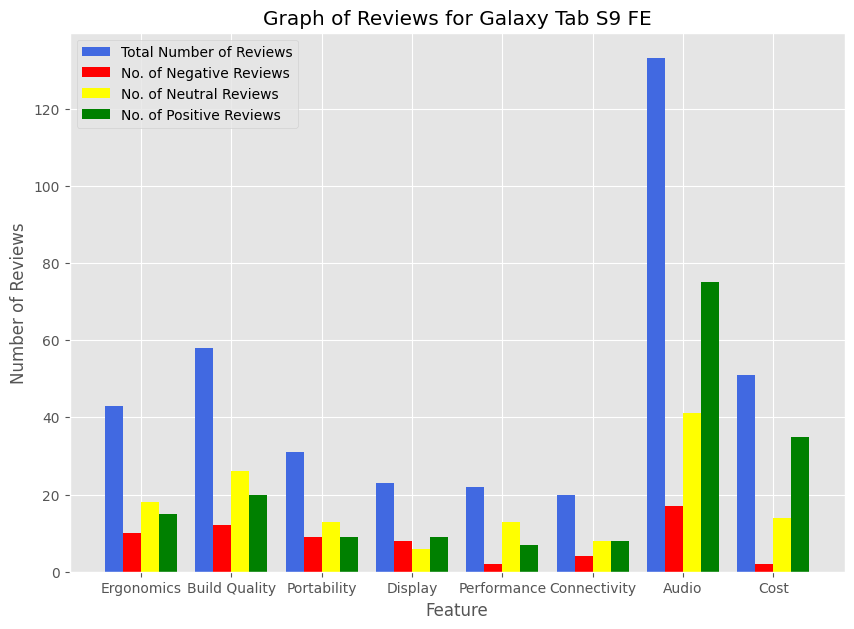

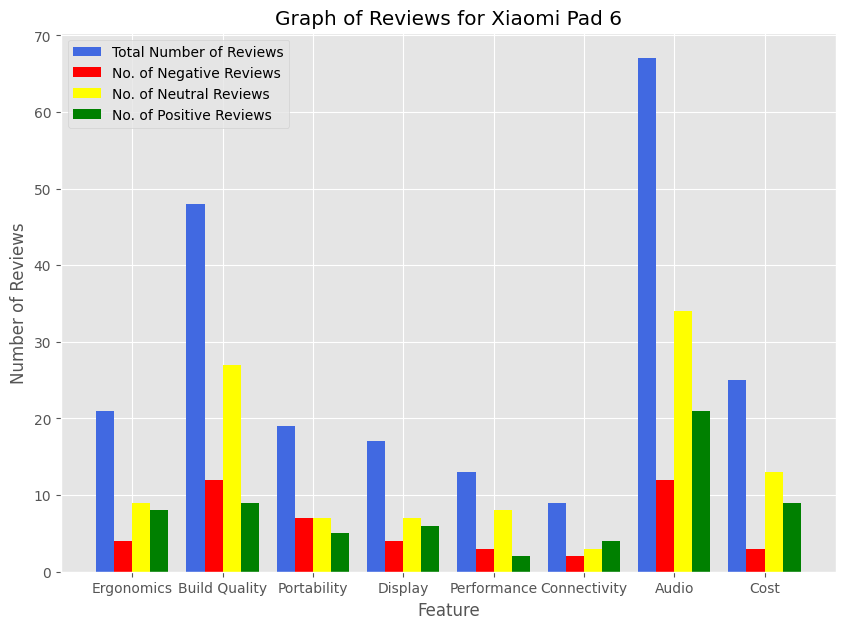

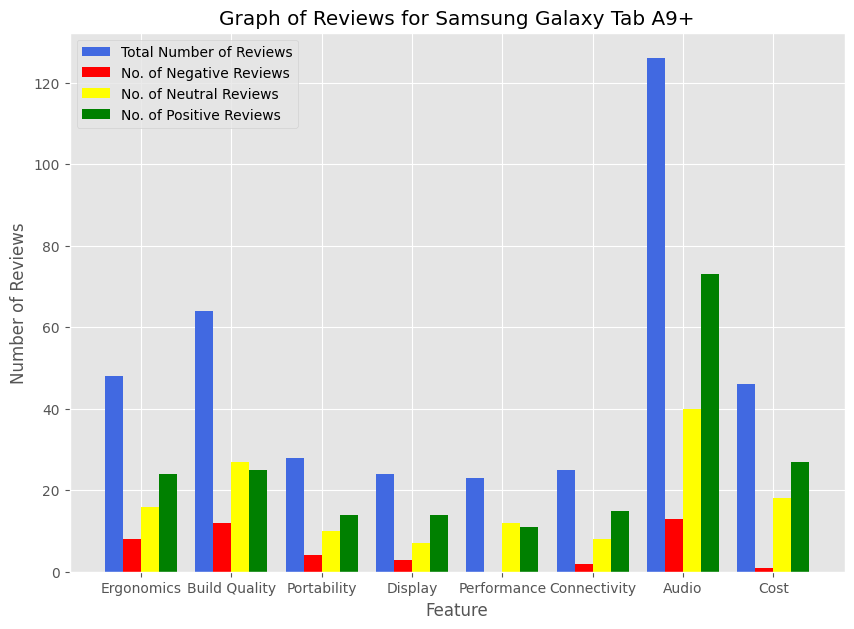

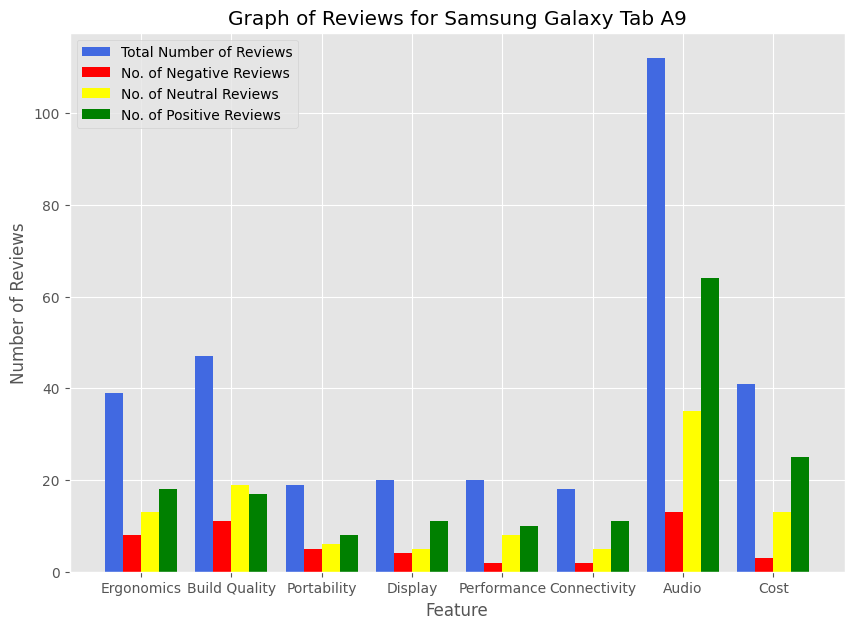

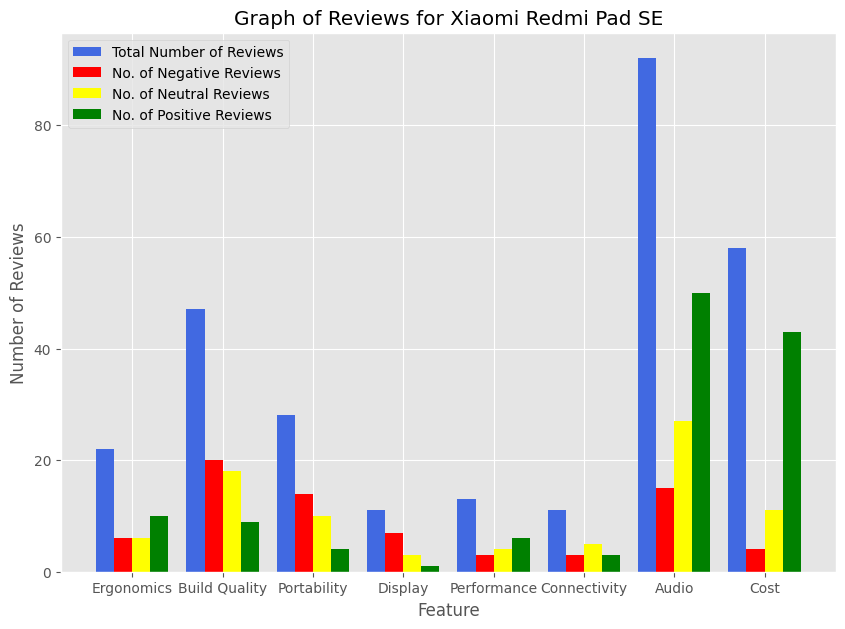

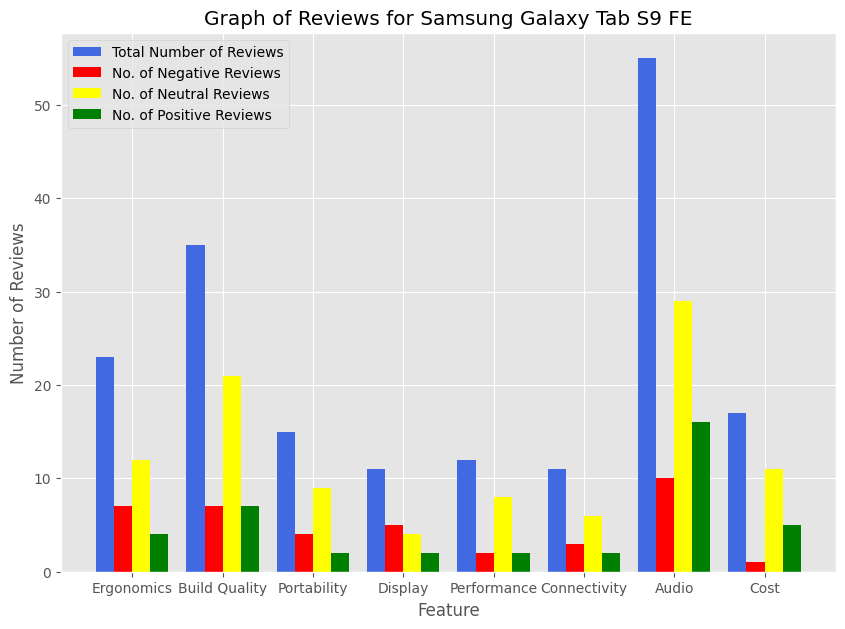

In [9]:
for i in range (len(products)):
    total_reviews=big_tuple_list[i][0]
    negative_reviews=big_tuple_list[i][1]
    neutral_reviews=big_tuple_list[i][2]
    positive_reviews=big_tuple_list[i][3]
    xpos = np.arange(len(total_reviews))

    style.use('ggplot')
    plt.figure(figsize=(10,7))
    barWidth = 0.2
    plt.bar(xpos, total_reviews, color='royalblue', width = barWidth, label='Total Number of Reviews')
    plt.bar(xpos+0.2, negative_reviews, color='red', width = barWidth, label='No. of Negative Reviews')
    plt.bar(xpos+0.4, neutral_reviews, color='yellow', width = barWidth, label='No. of Neutral Reviews')
    plt.bar(xpos+0.6, positive_reviews, color='green', width = barWidth, label='No. of Positive Reviews')
    plt.xticks(xpos+0.3, ('Ergonomics', 'Build Quality', 'Portability', 'Display', 'Performance', 'Connectivity', 'Audio', 'Cost'))
    plt.xlabel('Feature')
    plt.ylabel('Number of Reviews')
    plt.title(f'Graph of Reviews for {products[i]}')
    plt.legend()

Getting radar graph

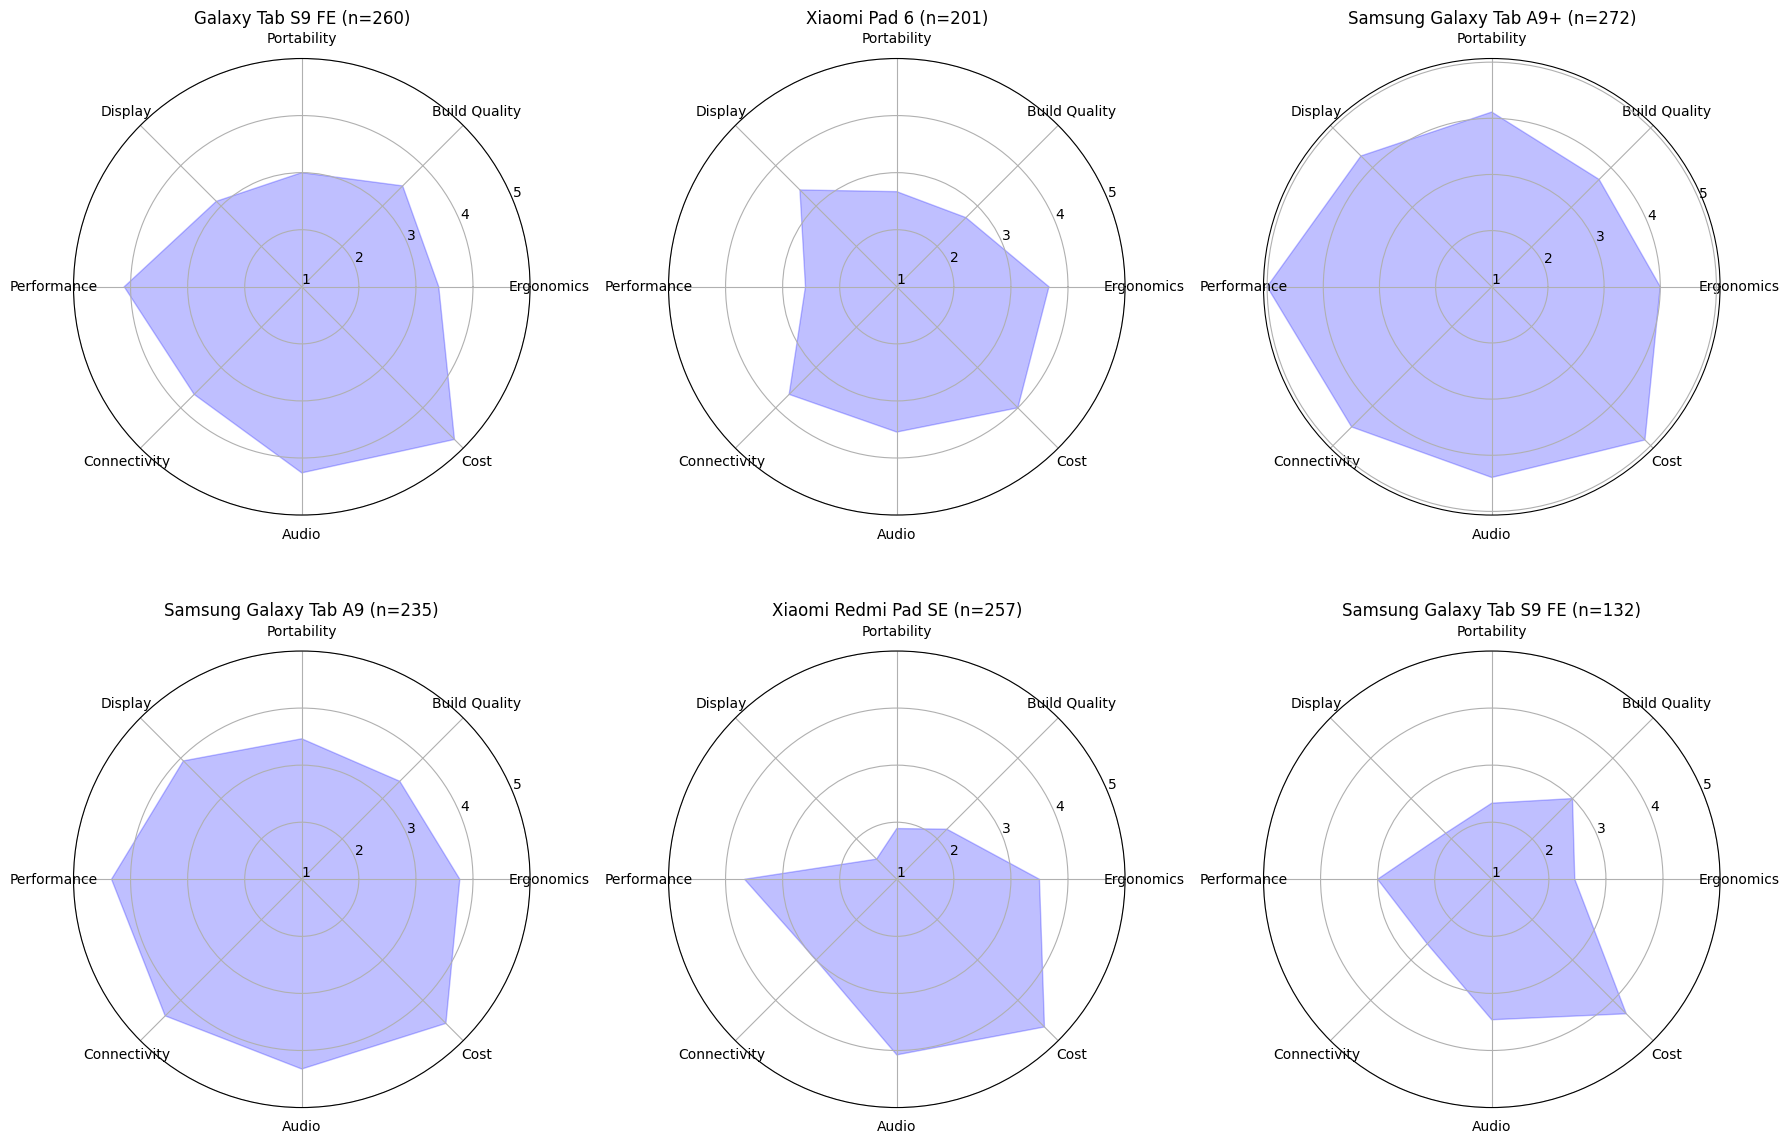

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Function to calculate the desired ratio
def calculate_ratio(entry):
    if (entry[3] + entry[1]) == 0:
        return(0.2)
    return entry[3] / (entry[3] + entry[1])

# Labels for each component of the radar chart
labels=[]
for i in range(len(candidates)):
    labels.append(candidates[i][0][:-8])

# Number of variables
num_vars = len(labels)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Make the plot close to a circle
angles += angles[:1]

# Plot all radar graphs side by side
fig, axs = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(polar=True))

for i, ax in enumerate(axs.flat):
    data = big_counter_list[i]
    ratios = [calculate_ratio(entry) for entry in data]
    ratios += ratios[:1]
    
    ax.fill(angles, ratios, color='blue', alpha=0.25)
    ax.set_yticks(np.linspace(0, 1, 5))  # Ensure all graphs have 5 yticks
    ax.set_yticklabels([1,2,3,4,5])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f'{products[i]} (n={len(comment_list[i])})')

plt.tight_layout()
plt.show()


Getting Pie Charts

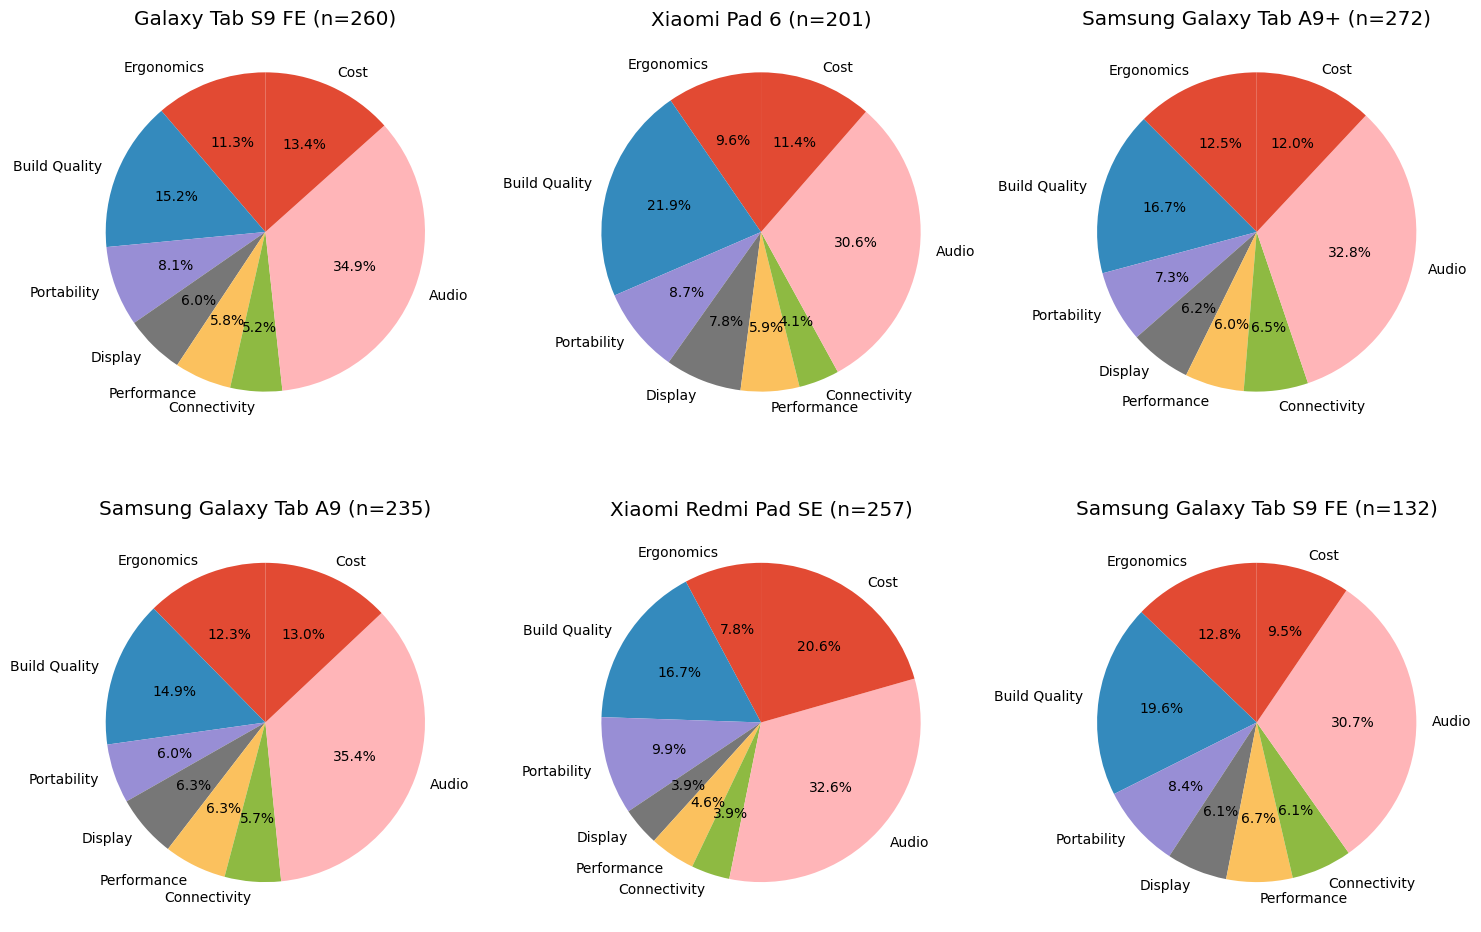

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
data=[]
for i in range (len(products)):
    total_reviews=big_tuple_list[i][0]
    data.append(total_reviews)

# Create subplots for 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Create pie charts for each set of data
for i in range(len(data)):
    # Plot pie chart
    sns.set_palette("husl", 9)  # Set color palette
    axes[i].pie(data[i], labels=[f'{candidates[j][0][:-8]}' for j in range(len(candidates))], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{products[i]} (n={len(comment_list[i])})')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


<h2>RAG and ChatGPT</h2>

Vectorise and store captions in persist directory

In [11]:
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY
for i in range(len(products)):
    from langchain_community.document_loaders import TextLoader

    loader = TextLoader(f"{data_dir}\{products[i]}\captions.txt", encoding='utf-8')

    document = loader.load()


    from langchain.text_splitter import RecursiveCharacterTextSplitter

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    splits = text_splitter.split_documents(document)

    print("Number of splits in document loaded:", len(splits))

    from langchain_openai import OpenAIEmbeddings
    embedding = OpenAIEmbeddings()


    import shutil
    import pandas as pd
    search_terms = pd.read_pickle(f"{data_dir}\{products[i]}\searchterm.pkl")
    print("Processing folder:", search_terms)

    try:
        shutil.rmtree(f"{data_dir}/{products[i]}/persist")       # remove old version
        print("Deleting previous store")
    except:
        print("No store found")

    persist_directory = f"{data_dir}/{products[i]}/persist"     # create new version


    from langchain_community.vectorstores import Chroma

    vectordb = Chroma.from_documents(
        documents=splits,                           # target the splits created from the documents loaded
        embedding=embedding,                        # use the OpenAI embedding specified
        persist_directory=persist_directory         # store in the persist directory for future use
    )

    vectordb.persist()                              # store vectordb

    print("Persist Directory created.")
    print("Size of Vector Database:", vectordb._collection.count())    # same as the number of splits


Number of splits in document loaded: 205
Processing folder: g
Deleting previous store
Persist Directory created.
Size of Vector Database: 205
Number of splits in document loaded: 129
Processing folder: a
Deleting previous store
Persist Directory created.
Size of Vector Database: 129
Number of splits in document loaded: 203
Processing folder: l
Deleting previous store
Persist Directory created.
Size of Vector Database: 203
Number of splits in document loaded: 152
Processing folder: a
Deleting previous store
Persist Directory created.
Size of Vector Database: 152
Number of splits in document loaded: 100
Processing folder: x
Deleting previous store
Persist Directory created.
Size of Vector Database: 100
Number of splits in document loaded: 215
Processing folder: y
Deleting previous store
Persist Directory created.
Size of Vector Database: 215


<h3>RAG with comments to get pros and cons</h3>

Converting comments and reviews into a .txt document

In [12]:
for i in range(len(products)):
    string=""
    for comm in comment_list[i]:
        string+=f"<<< {comm} >>>"
    with open(f'{data_dir}/{products[i]}/ragcom.txt', 'w', encoding='utf-8') as file:
        print(string)
        file.write(string)
    

<<< Whats up everyone I hope this comparison of the Tab S9 FE and the Tab S9 FE was helpful Did I cover what you wanted to know What else did you want to see or learn about Download the Best Buy app now for great deals a portion of this video is sponsored by Best Buy TAB S9 FE Buy the Tab S9 FE affiliate Buy the Tab S9 FE Book Cover Keyboard affiliate Buy the Tab S9 FE Book Cover Keyboard Slim affiliate TAB S9 FE Buy the Tab S9 FE affiliate Buy the Tab S9 FE Book Cover Keyboard affiliate Buy the Tab S9 FE Book Cover Keyboard Slim MICROSD 512GB Samsung Pro Plus affiliate 256GB Samsung Pro Plus affiliate ACCESSORIES Buy a 100W 4Port USB charger affiliate Buy a 45W 4Port USB charger affiliate Buy a tablet stand affiliate Buy a 7port USBC Hub affiliate FEATURED PRODUCT Samsung 65 Q80C QLED 4K TV affiliate >>><<< Give me wallpaper link >>><<< I am decades past being so tired of the companies producing every little inbetween nit picking models and versions >>><<< Those it have a sim tray >>>

Vectorise and store comments & reviews in another persist directory

In [13]:
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY
for i in range(len(products)):
    from langchain_community.document_loaders import TextLoader

    loader = TextLoader(f"{data_dir}\{products[i]}\\ragcom.txt", encoding='utf-8')

    document = loader.load()


    from langchain.text_splitter import RecursiveCharacterTextSplitter

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    splits = text_splitter.split_documents(document)

    print("Number of splits in document loaded:", len(splits))

    from langchain_openai import OpenAIEmbeddings
    embedding = OpenAIEmbeddings()


    import shutil
    import pandas as pd
    search_terms = pd.read_pickle(f"{data_dir}\{products[i]}\searchterm.pkl")
    print("Processing folder:", search_terms)

    try:
        shutil.rmtree(f"{data_dir}/{products[i]}/compersist")       # remove old version
        print("Deleting previous store")
    except:
        print("No store found")

    persist_directory = f"{data_dir}/{products[i]}/compersist"     # create new version


    from langchain_community.vectorstores import Chroma

    vectordb = Chroma.from_documents(
        documents=splits,                           # target the splits created from the documents loaded
        embedding=embedding,                        # use the OpenAI embedding specified
        persist_directory=persist_directory         # store in the persist directory for future use
    )

    vectordb.persist()                              # store vectordb

    print("Persist Directory created.")
    print("Size of Vector Database:", vectordb._collection.count())    # same as the number of splits


Number of splits in document loaded: 117
Processing folder: g
Deleting previous store
Persist Directory created.
Size of Vector Database: 117
Number of splits in document loaded: 49
Processing folder: a
Deleting previous store
Persist Directory created.
Size of Vector Database: 49
Number of splits in document loaded: 129
Processing folder: l
Deleting previous store
Persist Directory created.
Size of Vector Database: 129
Number of splits in document loaded: 116
Processing folder: a
Deleting previous store
Persist Directory created.
Size of Vector Database: 116
Number of splits in document loaded: 82
Processing folder: x
Deleting previous store
Persist Directory created.
Size of Vector Database: 82
Number of splits in document loaded: 40
Processing folder: y
Deleting previous store
Persist Directory created.
Size of Vector Database: 40


Getting Pros and Cons and a summary from ChatGPT

In [14]:
prosncons=""
for i in range(len(products)):
    from langchain_openai import ChatOpenAI
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0)               # gpt model can be changed
    from langchain.chains import RetrievalQA
    persist_directory = f"{data_dir}/{products[i]}/compersist"

    vectordb = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding
        )


    qa_chain = RetrievalQA.from_chain_type(
        llm,
        retriever=vectordb.as_retriever(search_type="mmr", search_kwargs={"k": 4, "fetch_k": 6}),
        # retriever=vectordb.as_retriever(search_type="similarity", search_kwargs={"k": 4}),
        # retriever=vectordb.as_retriever(),
        return_source_documents=True
        )

    question = f"What are 3 pros and 3 cons of the {products[i]}? Provide an overall summary of the {products[i]}"  # input question

    template = "If the review does not mention it, state 'It was not mentioned'."

    context = f"The text is from the amazon reviews and comments of youtube videos that reviewed the {products[i]}"

    prompt = context + question + template
    result = qa_chain({"query": prompt})

    print(f"\n--{products[i]}--")
    prosncons+=result["result"]
    prosncons+='\n'
    print(result["result"])

c:\Users\Matthew\Desktop\proj 2\.venv\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(



--Galaxy Tab S9 FE--
Based on the provided context, here are three pros and three cons of the Galaxy Tab S9 FE:

**Pros:**
1. **Display Quality:** The display of the Tab S9 FE is mentioned as being stellar, comparable to high-quality devices like the iPad Air 5th gen and the Tab S8.
2. **Optimization:** The 8GB and 256GB configuration is recommended for optimal performance with OneUI, suggesting good software and hardware integration.
3. **Versatility:** The device is suitable for various uses, including media consumption and potentially for music production, although the latter is not definitively confirmed.

**Cons:**
1. **Android Version:** There is a mention of the device coming with Android 13 and no available update to Android 14, which might be a downside for those seeking the latest software.
2. **Price:** It is implied that there might be concerns about the value, especially when considering the price difference between the standard and FE (Fan Edition) models.
3. **Hardware 

In [15]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0)               # gpt model can be changed
from langchain.chains import RetrievalQA
persist_directory = f"{data_dir}/{products[0]}/persist"
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
    )
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(search_type="mmr", search_kwargs={"k": 4, "fetch_k": 6}),
    # retriever=vectordb.as_retriever(search_type="similarity", search_kwargs={"k": 4}),
    # retriever=vectordb.as_retriever(),
    return_source_documents=True
    )
question = f"Infer what the business direction of the company behind {products[0]} is. "  # input question
template = "If the review does not imply it, state 'It was not implied'."
context = f"The text is from the caption of youtube videos that reviewed the {products[0]}. These reviewers are assumed to be more aware of the ongoing events in the tech industry."
prompt = context + question + template
result = qa_chain({"query": prompt})
print(f"\n-----Inferred Business Direction of the {products[i]}-----")
busdir=result['result']
print(result["result"])


persist_directory = f"{data_dir}/{products[0]}/compersist"
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
    )
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(search_type="mmr", search_kwargs={"k": 4, "fetch_k": 6}),
    # retriever=vectordb.as_retriever(search_type="similarity", search_kwargs={"k": 4}),
    # retriever=vectordb.as_retriever(),
    return_source_documents=True
    )

question = f"What are some general feedback about the {products[0]}? Provide some recommended design changes to the {products[0]} that aligns with the business direction here: {busdir}."  # input question
template = "If the review does not imply it, state 'It was not implied'."
context = f"The text is from the amazon reviews and comments of youtube videos that reviewed the {products[i]}"
prompt = context + question + template
result = qa_chain({"query": prompt})
print(f'-----Recommended design improvement for the {products[0]}-----\n')
print(result['result'])



-----Inferred Business Direction of the Samsung Galaxy Tab S9 FE-----
The business direction of the company behind the Galaxy Tab S9 FE, Samsung, appears to be focused on diversifying their product offerings to cater to different market segments. The introduction of the Galaxy Tab S9 FE as a "Fan Edition" suggests that Samsung aims to provide a more budget-friendly option for consumers who may not need or want the high-end features and price point of the premium models like the Galaxy Tab S9 Ultra. This strategy allows Samsung to appeal to a broader audience by offering a variety of products that can meet different needs and budgets.
-----Recommended design improvement for the Galaxy Tab S9 FE-----

The general feedback about the Samsung Galaxy Tab S9 FE from the provided text includes several positive points:

1. **Size and Display**: Users appreciate the large size of the tablet, which is ideal for watching movies and enhances media consumption.

2. **Performance**: Although it is n

<h3>Final reponse in a markdown cell for ease of reading</h3>
-----Inferred Business Direction of the Samsung Galaxy Tab S9 FE-----

The business direction of the company behind the Galaxy Tab S9 FE, Samsung, appears to be focused on diversifying their product offerings to cater to different market segments. The introduction of the Galaxy Tab S9 FE as a "Fan Edition" suggests that Samsung aims to provide a more budget-friendly option for consumers who may not need or want the high-end features and price point of the premium models like the Galaxy Tab S9 Ultra. This strategy allows Samsung to appeal to a broader audience by offering a variety of products that can meet different needs and budgets.

-----Recommended design improvement for the Galaxy Tab S9 FE-----

The general feedback about the Samsung Galaxy Tab S9 FE from the provided text includes several positive points:

1. **Size and Display**: Users appreciate the large size of the tablet, which is ideal for watching movies and enhances media consumption.

2. **Performance**: Although it is not as fast as the flagship models, the Tab S9 FE is described as smooth and quick, adequately serving the needs for business work and general usage.

3. **Durability**: The tablet is noted for being water and dust resistant, which adds to its utility by making it more durable in various environments.

4. **Connectivity Options**: The availability of 5G options is positively noted, enhancing its appeal for users needing faster internet speeds on the go.

5. **Design and Aesthetics**: Users like the availability of different color options for the Tab S9 FE, which is not as limited as in other models.

However, there are also some areas for improvement:
- The absence of a Snapdragon chip is mentioned as a downside, suggesting that the performance could be enhanced with better hardware.
- It was not implied if there are any specific design changes recommended by users.

Based on the feedback and the business direction of Samsung, here are some recommended design changes for the Galaxy Tab S9 FE:
1. **Hardware Upgrades**: Introduce a version with a Snapdragon processor option to cater to users who might need more powerful performance but still want a cost-effective solution.
2. **Expand Color and Design Options**: Continue to diversify the aesthetic options, perhaps introducing limited edition designs or collaborations to make the product feel more personalized and appealing.
3. **Enhanced Camera Features**: While the camera is deemed good enough, enhancing camera capabilities could make the tablet more appealing to a broader audience, including those who use it for content creation.
4. **Sustainability Features**: Introduce features that appeal to environmentally conscious consumers, such as using recycled materials for the casing or offering a trade-in discount program to encourage recycling of older devices.
5. **Software Updates and Support**: Ensure that the Tab S9 FE receives timely software updates, including new Android versions, to keep it relevant and secure over a longer period.

These changes could help Samsung further align the Galaxy Tab S9 FE with consumer needs while sticking to their strategy of diversification and accessibility.


<h2>Benchmarking Section</h2>

Collating randomm coments and reviews into an excel for benchmarking of EDA model

In [16]:
benchlist=[]
for i in range(len(products)):
    for com in range(5):
        tempcombench=[]
        comment=big_final_list[i][0][com*20+5]['sequence']
        comaisent=big_final_list[i][0][com*20+5]['label'][-1]
        candscore=""
        for j in range(len(candidates)):
            comaicat=big_final_list[i][j][com*20+5]['labels'][0]
            candscore+=comaicat
            if j!=7:
                candscore+=", "
        tempcombench=[comment,comaisent,"",candscore,""]
        benchlist.append(tempcombench)

In [17]:
with open(f'{data_dir}/benchmark.csv', 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Comment/Review', 'AI Sentiment', "Human Sentiment",'AI Categories', "Human Verified Category Score"])
    for bench in benchlist:
        csv_writer.writerow(bench)

In [15]:
print(len(comment_list[4]))

257
